In [ ]:
# ================================
# 1. Install & Import Libraries
# ================================
!pip install kaggle tensorflow tensorflow-datasets matplotlib

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import files
files.upload()  # choose kaggle.json from your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pankajkumardev","key":"a8fdd84e94906e6f357318fccde6e0b1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ================================
# 2. Download Chest X-ray Dataset
# (positive class = X-ray)
# ================================
# Make sure you already have Kaggle API key set up (~/.kaggle/kaggle.json)

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p ./data
!unzip -q ./data/chest-xray-pneumonia.zip -d ./data

# We will use "chest_xray/train" folder
xray_dir = "./data/chest_xray/train"

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.26G/2.29G [00:26<00:00, 96.3MB/s]
100% 2.29G/2.29G [00:26<00:00, 92.9MB/s]


In [ ]:
import os

xray_dir = "./data/chest_xray/train"

print("Train folder path:", xray_dir)
print("Classes inside train folder:", os.listdir(xray_dir))

Train folder path: ./data/chest_xray/train
Classes inside train folder: ['NORMAL', 'PNEUMONIA']


In [ ]:
# ================================
# 3. Get Non-X-ray Dataset
# (negative class = natural images)
# ================================
# We'll use CIFAR-10 dataset as "non-xray" proxy
cifar, info = tfds.load("cifar10", split="train", with_info=True, as_supervised=True)

def resize_and_save(dataset, outdir, limit=5000):
    os.makedirs(outdir, exist_ok=True)
    i = 0
    for img, label in tfds.as_numpy(dataset):
        if i >= limit:
            break
        img_pil = tf.keras.preprocessing.image.array_to_img(img)
        img_pil = img_pil.resize((224, 224))
        img_pil.save(os.path.join(outdir, f"nonxray_{i}.jpg"))
        i += 1

nonxray_dir = "./data/non_xray"
resize_and_save(cifar, nonxray_dir, limit=5000)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.QSO2I7_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.QSO2I7_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# ================================
# 4. Create Train/Validation Folders
# ================================
base_dir = "./data/xray_vs_nonxray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

for d in [train_dir, val_dir]:
    os.makedirs(os.path.join(d, "xray"), exist_ok=True)
    os.makedirs(os.path.join(d, "nonxray"), exist_ok=True)

# Copy some chest xray images into "xray"
!cp -r ./data/chest_xray/train/NORMAL/* $train_dir/xray/
!cp -r ./data/chest_xray/train/PNEUMONIA/* $train_dir/xray/
!cp -r ./data/chest_xray/val/NORMAL/* $val_dir/xray/
!cp -r ./data/chest_xray/val/PNEUMONIA/* $val_dir/xray/

# Copy CIFAR-10 images into "nonxray"
!cp ./data/non_xray/*.jpg $train_dir/nonxray/
!cp ./data/non_xray/*.jpg $val_dir/nonxray/

In [ ]:
# ================================
# 5. Data Generators
# ================================
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_gen = train_datagen.flow_from_directory(
    base_dir + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    base_dir + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

Found 8173 images belonging to 2 classes.
Found 2043 images belonging to 2 classes.


In [ ]:
# ================================
# 6. Build Model
# ================================
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1, activation="sigmoid")(x)

xray_filter_model = Model(inputs=base_model.input, outputs=x)

xray_filter_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# ================================
# 7. Train Model
# ================================
history = xray_filter_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 225s 808ms/step - accuracy: 0.9424 - loss: 0.1456 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 152s 594ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 152s 596ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 7.0195e-04
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 151s 590ms/step - accuracy: 1.0000 - loss: 5.5037e-04 - val_accuracy: 1.0000 - val_loss: 4.1778e-04
Epoch 5/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 151s 590ms/step - accuracy: 1.0000 - loss: 3.5421e-04 - val_accuracy: 1.0000 - val_loss: 3.3207e-04


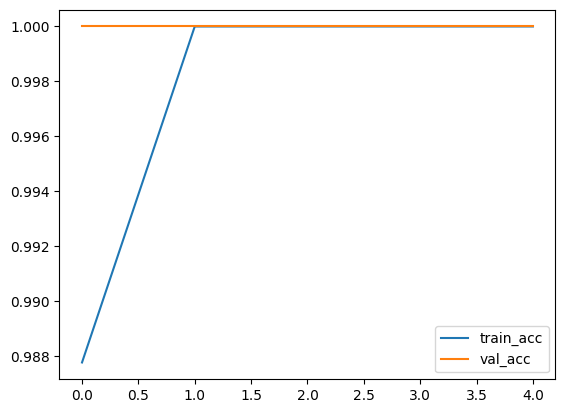

In [ ]:
# ================================
# 8. Evaluate Model
# ================================
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

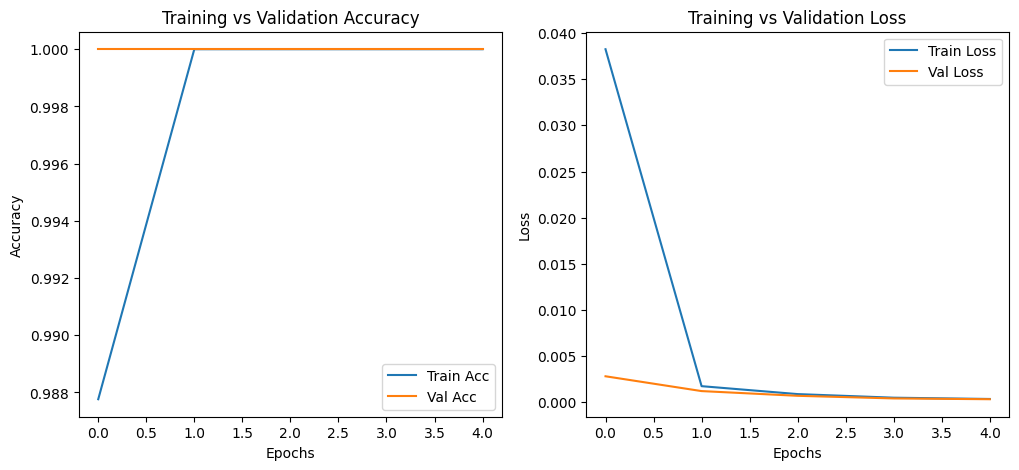

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# 1. Plot Training Curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

In [ ]:
# 2. Predictions on Validation Set
val_gen.reset()
y_true = val_gen.classes
y_pred_probs = xray_filter_model.predict(val_gen, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int)

64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 742ms/step


In [ ]:
# 3. Classification Report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))

📊 Classification Report:
              precision    recall  f1-score   support

     nonxray       0.49      0.49      0.49      1000
        xray       0.51      0.51      0.51      1043

    accuracy                           0.50      2043
   macro avg       0.50      0.50      0.50      2043
weighted avg       0.50      0.50      0.50      2043



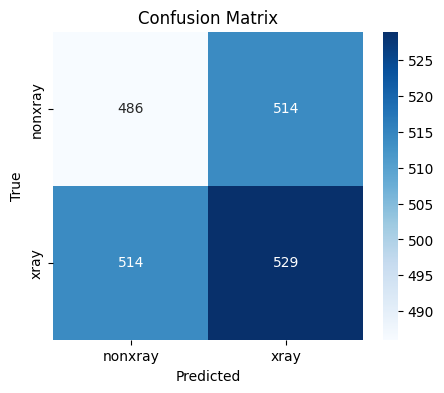

In [ ]:
# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

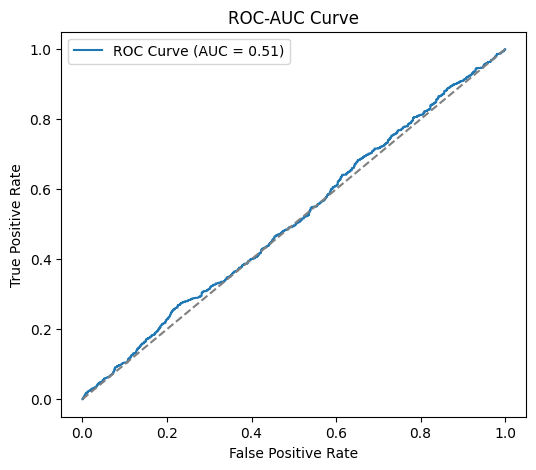

In [ ]:
# 5. ROC-AUC Curve
roc_auc = roc_auc_score(y_true, y_pred_probs)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

In [ ]:
# ================================
# 9. Save Model
# ================================
os.makedirs("models", exist_ok=True)
xray_filter_model.save("models/xray_filter.h5")

print("✅ Model saved as models/xray_filter.h5")


✅ Model saved as models/xray_filter.h5


# Lets test this model

In [3]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# 1. Load the trained model
model_path = "models/xray_filter.h5"
xray_filter_model = load_model(model_path)
print("✅ Model loaded successfully.")

✅ Model loaded successfully.


In [4]:
# 2. Define labels (update if order is different in your training generator)
class_labels = ["nonxray", "xray"]

# 3. Function to preprocess and predict
def predict_image(img_path):
    try:
        # Load image (resize to model input size, e.g. 224x224 — adjust if different)
        img = image.load_img(img_path, target_size=(224, 224))

        # Convert to array and normalize
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # shape: (1, height, width, channels)

        # Predict
        prediction = xray_filter_model.predict(img_array, verbose=0)

        # If sigmoid (binary classifier)
        if prediction.shape[-1] == 1:
            pred_class = int(prediction[0][0] > 0.5)
            confidence = float(prediction[0][0]) if pred_class == 1 else 1 - float(prediction[0][0])
        else:
            # If softmax (2-class output)
            pred_class = np.argmax(prediction[0])
            confidence = float(np.max(prediction[0]))

        print(f"🖼️ Image: {os.path.basename(img_path)}")
        print(f"📌 Prediction: {class_labels[pred_class]} (Confidence: {confidence:.2f})")
        return class_labels[pred_class], confidence

    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")
        return None, None

In [5]:
# 4. Example usage
if __name__ == "__main__":
    test_image = "/content/Other_2.webp"
    predict_image(test_image)

🖼️ Image: Other_2.webp
📌 Prediction: xray (Confidence: 0.67)
